# EMPCA EM Process Visualization (Week 4)

This notebook visualizes EM-PCA iterative refinement without changing `reusable/empca_TCY_optimized.py`.

It tracks and plots:
- objective (`chi2`) per EM iteration,
- template/component refinement (`eigvec`) over iterations,
- coefficient refinement (`coeff`) over iterations,
- weighted residual distribution improvement.


In [1]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py


def _repo_root():
    here = Path.cwd().resolve()
    cands = [here, here.parent, here.parent.parent]
    for c in cands:
        if (c / 'wk4').exists() and (c / 'reusable').exists():
            return c
        if (c / 'PCA_dev' / 'wk4').exists() and (c / 'PCA_dev' / 'reusable').exists():
            return c / 'PCA_dev'
    raise RuntimeError('Run from DELight_mtr, PCA_dev, or PCA_dev/wk4')


repo = _repo_root()
reusable_dir = repo / 'reusable'
if str(reusable_dir) not in sys.path:
    sys.path.insert(0, str(reusable_dir))

from empca_TCY_optimized import empca_solver, smooth, ti_rfft, ti_irfft

print('repo =', repo)


repo = /home/dwong/DELight_mtr/PCA_dev


In [2]:
# Data config
TRACE_H5 = repo / 'reusable' / 'k_alpha' / 'k_alpha_traces.h5'
DATASET_KEY = 'traces'
MAX_EVENTS = 300
PRETRIGGER = 2000

if not TRACE_H5.exists():
    raise FileNotFoundError(f'Missing trace file: {TRACE_H5}')

with h5py.File(TRACE_H5, 'r') as f:
    if DATASET_KEY not in f:
        raise KeyError(f"Dataset '{DATASET_KEY}' not found in {TRACE_H5}. Keys: {list(f.keys())}")
    X_time = np.asarray(f[DATASET_KEY][:MAX_EVENTS], dtype=np.float64)

if X_time.ndim != 2:
    raise ValueError(f'Expected 2D traces, got shape {X_time.shape}')
if PRETRIGGER < 1 or PRETRIGGER > X_time.shape[1]:
    raise ValueError(f'PRETRIGGER must be in [1, n_time], got {PRETRIGGER}')

baseline = X_time[:, :PRETRIGGER].mean(axis=1, keepdims=True)
X0 = X_time - baseline

print('X_time shape:', X_time.shape)
print('X0 shape    :', X0.shape)
print('baseline mean across events:', float(np.mean(baseline)))
print('baseline std  across events:', float(np.std(baseline)))


X_time shape: (300, 32768)
X0 shape    : (300, 32768)
baseline mean across events: 130.78399833333333
baseline std  across events: 1.1039631224957451


In [3]:
# Frequency-domain features and noise weights
EPS = 1e-18
NOISE_KIND = 'mmc'  # 'mmc', 'white', or 'pink'

NOISE_PATHS = {
    'mmc': Path('/ceph/dwong/delight/noise_psd_xray.npy'),
    'white': repo / 'reusable' / 'weight' / 'noise_psd_white.npy',
    'pink': repo / 'reusable' / 'weight' / 'noise_psd_pink.npy',
}


def load_psd_1d(path: Path):
    arr = np.load(path)
    arr = np.asarray(arr)
    freq = None
    if arr.ndim == 2 and arr.shape[0] == 2:
        freq = np.asarray(arr[0], dtype=np.float64)
        arr = arr[1]
    if arr.ndim != 1:
        raise ValueError(f'PSD must be 1D or shape (2,n). Got {arr.shape} from {path}')
    return freq, arr.astype(np.float64)


X_tilde = ti_rfft(X0)
if X_tilde.ndim != 2:
    raise RuntimeError(f'ti_rfft output must be 2D; got {X_tilde.shape}')

n_obs, n_freq = X_tilde.shape
noise_path = NOISE_PATHS[NOISE_KIND]
if not noise_path.exists():
    print(f'WARNING: {noise_path} missing. Falling back to white noise PSD.')
    noise_path = NOISE_PATHS['white']

noise_freq, noise_psd = load_psd_1d(noise_path)
if noise_psd.shape[0] != n_freq:
    raise ValueError(f'PSD bins {noise_psd.shape[0]} do not match feature bins {n_freq}')

w = 1.0 / (noise_psd + EPS)

print('X_tilde shape :', X_tilde.shape)
print('noise kind    :', NOISE_KIND)
print('noise path    :', noise_path)
print('weights shape :', w.shape)
print('weights min/max:', float(np.min(w)), float(np.max(w)))


X_tilde shape : (300, 16385)
noise kind    : mmc
noise path    : /ceph/dwong/delight/noise_psd_xray.npy
weights shape : (16385,)
weights min/max: 727.7709339186614 582032.7218167391


In [4]:
# Run EM one iteration at a time and record history
N_COMP = 3
N_ITER = 20
MODE = 'fast'
SMOOTH_WINDOW = 15
SMOOTH_POLYORD = 3
SMOOTH_DERIV = 0

# Keep snapshots for visual overlays
snapshot_iters = sorted(set([0, 1, 2, 5, N_ITER // 2, 10, N_ITER]))

solver = empca_solver(N_COMP, X_tilde, w)


def weighted_residual_per_event(coeff, eigvec, X_feat, weight_vec):
    resid = X_feat - coeff @ eigvec
    return np.sum((np.abs(resid) ** 2) * weight_vec[None, :], axis=1)


chi2_history = []
eig_delta_history = [np.nan]
coeff_delta_history = [np.nan]
resid_mean_history = []
coeff_history = []

coeff_snapshots = {}
eigvec_snapshots = {}
resid_snapshots = {}

# Iteration 0 (initial random eigvec + solved coeff)
coeff_history.append(solver.coeff.copy())
chi2_history.append(float(solver.chi2()))
res0 = weighted_residual_per_event(solver.coeff, solver.eigvec, X_tilde, w)
resid_mean_history.append(float(np.mean(res0)))

if 0 in snapshot_iters:
    coeff_snapshots[0] = solver.coeff.copy()
    eigvec_snapshots[0] = solver.eigvec.copy()
    resid_snapshots[0] = res0.copy()

for it in range(1, N_ITER + 1):
    eig_prev = solver.eigvec.copy()
    coeff_prev = solver.coeff.copy()

    solver.eigvec = smooth(
        solver.solve_eigvec(mode=MODE),
        window=SMOOTH_WINDOW,
        polyord=SMOOTH_POLYORD,
        deriv=SMOOTH_DERIV,
    )
    solver.coeff = solver.solve_coeff()

    chi2 = float(solver.chi2())
    chi2_history.append(chi2)
    coeff_history.append(solver.coeff.copy())

    eig_prev_norm = max(np.linalg.norm(eig_prev), EPS)
    coeff_prev_norm = max(np.linalg.norm(coeff_prev), EPS)
    eig_delta = float(np.linalg.norm(solver.eigvec - eig_prev) / eig_prev_norm)
    coeff_delta = float(np.linalg.norm(solver.coeff - coeff_prev) / coeff_prev_norm)
    eig_delta_history.append(eig_delta)
    coeff_delta_history.append(coeff_delta)

    res = weighted_residual_per_event(solver.coeff, solver.eigvec, X_tilde, w)
    resid_mean_history.append(float(np.mean(res)))

    if it in snapshot_iters:
        coeff_snapshots[it] = solver.coeff.copy()
        eigvec_snapshots[it] = solver.eigvec.copy()
        resid_snapshots[it] = res.copy()

    if it % 5 == 0 or it == 1 or it == N_ITER:
        print(f'iter={it:02d} chi2={chi2:.6e} eig_delta={eig_delta:.3e} coeff_delta={coeff_delta:.3e}')

coeff_history = np.asarray(coeff_history)

print('Recorded iterations:', len(chi2_history))
print('coeff_history shape:', coeff_history.shape)
print('snapshot_iters     :', snapshot_iters)


iter=01 chi2=6.416520e+18 eig_delta=1.136e+00 coeff_delta=1.186e+04
iter=05 chi2=6.376202e+18 eig_delta=8.144e-02 coeff_delta=4.634e-02
iter=10 chi2=6.342664e+18 eig_delta=3.903e-02 coeff_delta=4.257e-02
iter=15 chi2=6.338046e+18 eig_delta=3.328e-02 coeff_delta=4.188e-02
iter=20 chi2=6.337648e+18 eig_delta=3.185e-02 coeff_delta=4.176e-02
Recorded iterations: 21
coeff_history shape: (21, 300, 3)
snapshot_iters     : [0, 1, 2, 5, 10, 20]


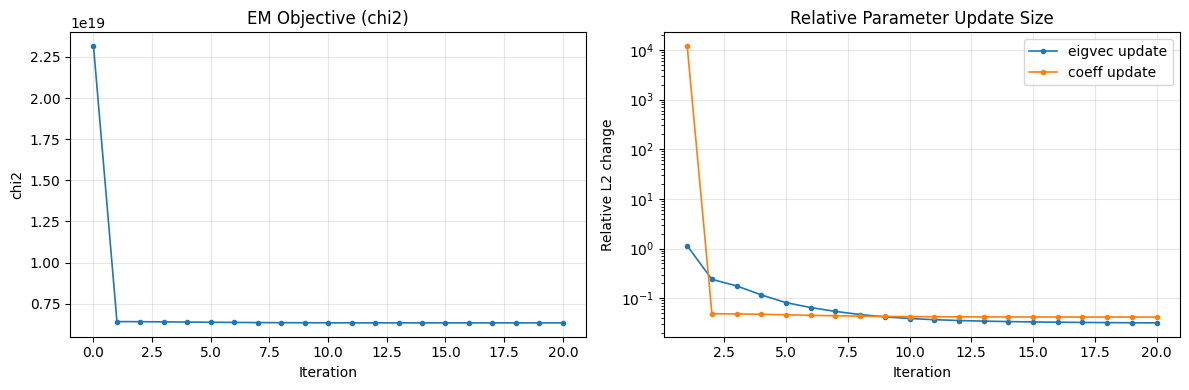

In [5]:
# Plot A: convergence and update sizes
iters = np.arange(len(chi2_history))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(iters, chi2_history, marker='o', ms=3, lw=1.2)
axes[0].set_title('EM Objective (chi2)')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('chi2')
axes[0].grid(alpha=0.3)

axes[1].semilogy(iters[1:], eig_delta_history[1:], marker='o', ms=3, lw=1.2, label='eigvec update')
axes[1].semilogy(iters[1:], coeff_delta_history[1:], marker='o', ms=3, lw=1.2, label='coeff update')
axes[1].set_title('Relative Parameter Update Size')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Relative L2 change')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


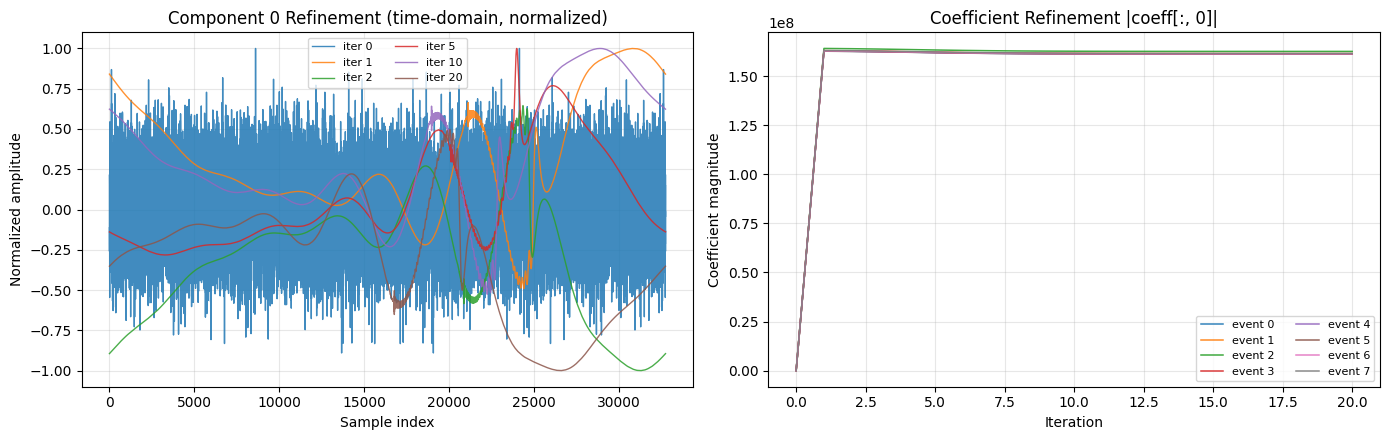

In [6]:
# Plot B: template/component refinement and coefficient trajectories
COMPONENT_TO_VIEW = 0
N_EVENTS_TO_TRACK = 8
EVENT_IDS = np.arange(min(N_EVENTS_TO_TRACK, X_tilde.shape[0]))

snap = sorted(eigvec_snapshots.keys())
iters = np.arange(coeff_history.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

# Left: time-domain component template overlays
for it in snap:
    comp_f = eigvec_snapshots[it][COMPONENT_TO_VIEW]
    comp_t = np.real(ti_irfft(comp_f))
    scale = max(np.max(np.abs(comp_t)), EPS)
    axes[0].plot(comp_t / scale, lw=1.0, alpha=0.85, label=f'iter {it}')

axes[0].set_title(f'Component {COMPONENT_TO_VIEW} Refinement (time-domain, normalized)')
axes[0].set_xlabel('Sample index')
axes[0].set_ylabel('Normalized amplitude')
axes[0].grid(alpha=0.3)
axes[0].legend(ncol=2, fontsize=8)

# Right: coefficient magnitude trajectories for selected events
for ev in EVENT_IDS:
    traj = np.abs(coeff_history[:, ev, COMPONENT_TO_VIEW])
    axes[1].plot(iters, traj, lw=1.1, alpha=0.9, label=f'event {ev}')

axes[1].set_title(f'Coefficient Refinement |coeff[:, {COMPONENT_TO_VIEW}]|')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Coefficient magnitude')
axes[1].grid(alpha=0.3)
axes[1].legend(ncol=2, fontsize=8)

plt.tight_layout()
plt.show()


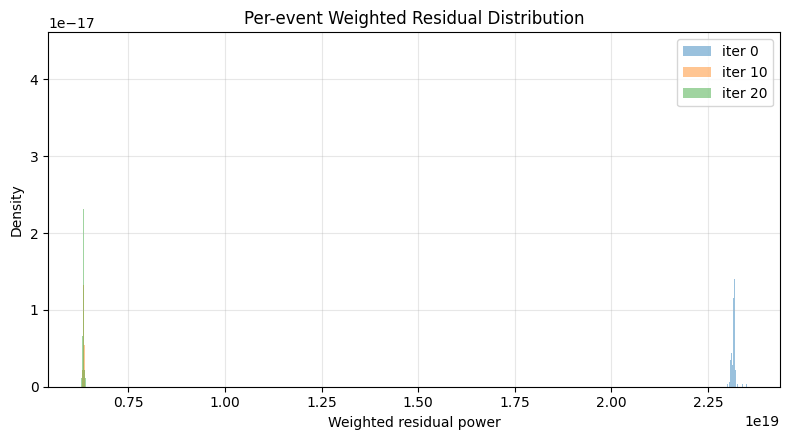

In [7]:
# Plot C: weighted residual distributions (early/mid/final)
check_iters = sorted(set([0, N_ITER // 2, N_ITER]))

fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
for it in check_iters:
    if it not in resid_snapshots:
        coeff_it = coeff_history[it]
        eig_it = eigvec_snapshots.get(it, solver.eigvec)
        resid_it = weighted_residual_per_event(coeff_it, eig_it, X_tilde, w)
    else:
        resid_it = resid_snapshots[it]
    ax.hist(resid_it, bins=50, alpha=0.45, density=True, label=f'iter {it}')

ax.set_title('Per-event Weighted Residual Distribution')
ax.set_xlabel('Weighted residual power')
ax.set_ylabel('Density')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


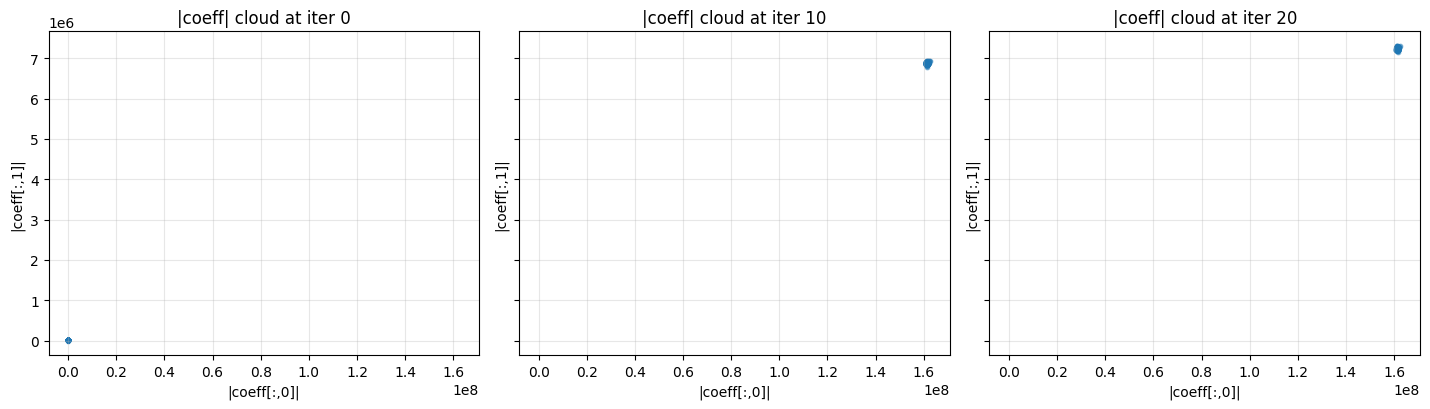

In [8]:
# Plot D: joint view of coefficient cloud evolution
selected = sorted(set([0, N_ITER // 2, N_ITER]))

fig, axes = plt.subplots(1, len(selected), figsize=(4.8 * len(selected), 4.2), sharex=True, sharey=True)
if len(selected) == 1:
    axes = [axes]

for ax, it in zip(axes, selected):
    c0 = np.abs(coeff_history[it, :, 0])
    c1 = np.abs(coeff_history[it, :, 1]) if N_COMP > 1 else np.zeros_like(c0)
    ax.scatter(c0, c1, s=10, alpha=0.5)
    ax.set_title(f'|coeff| cloud at iter {it}')
    ax.set_xlabel('|coeff[:,0]|')
    ax.set_ylabel('|coeff[:,1]|')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
